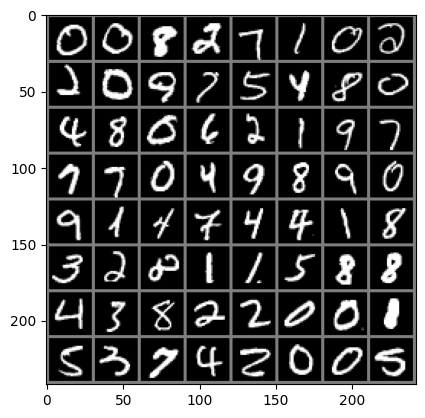

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Define a transform to normalize the data (mean 0.5, deviation 0.5)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Visualize some images from the dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(images))


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # 784 input nodes, 128 in the hidden layer
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 output nodes (for 10 digits)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [3]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Training the network
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')


[Epoch 1, Batch 100] loss: 1.302
[Epoch 1, Batch 200] loss: 0.471
[Epoch 1, Batch 300] loss: 0.369
[Epoch 1, Batch 400] loss: 0.315
[Epoch 1, Batch 500] loss: 0.304
[Epoch 1, Batch 600] loss: 0.261
[Epoch 1, Batch 700] loss: 0.246
[Epoch 1, Batch 800] loss: 0.242
[Epoch 1, Batch 900] loss: 0.225
[Epoch 2, Batch 100] loss: 0.213
[Epoch 2, Batch 200] loss: 0.196
[Epoch 2, Batch 300] loss: 0.174
[Epoch 2, Batch 400] loss: 0.170
[Epoch 2, Batch 500] loss: 0.177
[Epoch 2, Batch 600] loss: 0.156
[Epoch 2, Batch 700] loss: 0.169
[Epoch 2, Batch 800] loss: 0.143
[Epoch 2, Batch 900] loss: 0.148
[Epoch 3, Batch 100] loss: 0.121
[Epoch 3, Batch 200] loss: 0.131
[Epoch 3, Batch 300] loss: 0.124
[Epoch 3, Batch 400] loss: 0.132
[Epoch 3, Batch 500] loss: 0.125
[Epoch 3, Batch 600] loss: 0.131
[Epoch 3, Batch 700] loss: 0.134
[Epoch 3, Batch 800] loss: 0.130
[Epoch 3, Batch 900] loss: 0.110
[Epoch 4, Batch 100] loss: 0.095
[Epoch 4, Batch 200] loss: 0.111
[Epoch 4, Batch 300] loss: 0.101
[Epoch 4, 

In [4]:
correct = 0
total = 0
with torch.no_grad():  # We don't need gradients for evaluation
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 10000 test images: 97.53%


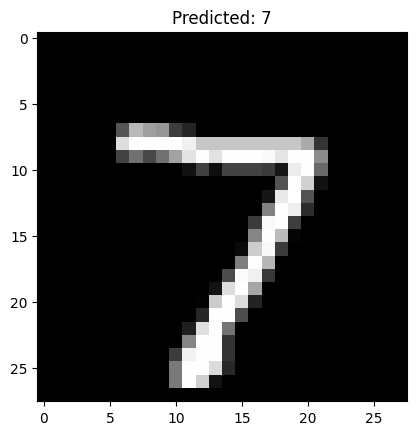

Actual Label: 7, Predicted Label: 7


In [5]:
import numpy as np

# Function to predict a single image
def predict_image(image):
    # Convert the image to a tensor and add a batch dimension
    image_tensor = image.view(1, 28 * 28)

    # Perform the prediction
    output = net(image_tensor)
    _, predicted = torch.max(output.data, 1)
    
    return predicted.item()

# Function to display the image and prediction
def display_prediction(image, label):
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.title(f'Predicted: {label}')
    plt.show()

# Get a single image from the test set
dataiter = iter(testloader)
images, labels = next(dataiter)

# Pick an image index to predict (for example, the first image in the batch)
image_index = 0
image = images[image_index]
label = labels[image_index].item()

# Predict and display the result
predicted_label = predict_image(image)
display_prediction(image, predicted_label)

print(f'Actual Label: {label}, Predicted Label: {predicted_label}')


In [8]:
import tkinter as tk
from tkinter import Button
from PIL import Image, ImageDraw, ImageOps
import torch
import torchvision.transforms as transforms

# Define the drawing interface class
class DrawingApp:
    def __init__(self, root, model):
        self.root = root
        self.model = model
        self.root.title("Draw a digit")

        self.canvas = tk.Canvas(self.root, width=200, height=200, bg="white")
        self.canvas.pack()

        self.image1 = Image.new("L", (200, 200), 255)
        self.draw = ImageDraw.Draw(self.image1)

        self.canvas.bind("<B1-Motion>", self.paint)

        self.button_predict = Button(self.root, text="Predict", command=self.predict_digit)
        self.button_predict.pack()

        self.label_result = tk.Label(self.root, text="Draw a digit and click Predict")
        self.label_result.pack()

    def paint(self, event):
        # Draw lines on the canvas and on the image
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        self.canvas.create_oval(x1, y1, x2, y2, fill="black", width=15)
        self.draw.line([x1, y1, x2, y2], fill=0, width=15)

    def predict_digit(self):
        # Resize, invert and normalize the image
        image = self.image1.resize((28, 28))
        image = ImageOps.invert(image)
        image = image.convert("L")
        image = transforms.ToTensor()(image)
        image = transforms.Normalize((0.5,), (0.5,))(image)
        image = image.view(1, 28 * 28)

        # Make the prediction
        output = self.model(image)
        _, predicted = torch.max(output.data, 1)
        self.label_result.config(text=f'Predicted: {predicted.item()}')

        # Clear the canvas for the next drawing
        self.canvas.delete("all")
        self.image1 = Image.new("L", (200, 200), 255)
        self.draw = ImageDraw.Draw(self.image1)

# Instantiate and run the GUI
def run_drawing_app(model):
    root = tk.Tk()
    app = DrawingApp(root, model)
    root.mainloop()

# Example usage
run_drawing_app(net)
